In [1]:
# !pip install --upgrade git+https://github.com/google/lightweight_mmm.git

In [ ]:

from lightweight_mmm import plot
from lightweight_mmm import preprocessing, lightweight_mmm
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("husl")
sns.set_style('darkgrid')

In [29]:
df = pd.read_csv('./Data/data.csv')

# 1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
st_cols = ['st_ct']
# markdown/discount variables
mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
base_vars = me_cols+st_cols+mrkdn_cols#+hldy_cols+seas_cols

# 3. sales variables
sales_cols =['sales']

df['wk_strt_dt'] = pd.to_datetime(df['wk_strt_dt'])
df.drop(columns=['yr_nbr', 'qtr_nbr', 'prd', 'wk_nbr', 'wk_in_yr_nbr', 'va_pub_0.15','va_pub_0.2', 'va_pub_0.25', 'va_pub_0.3'], inplace=True)

df[['wk_strt_dt']+mdip_cols+['sales']].head()

,wk_strt_dt,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,mdip_sms,mdip_aff,mdip_sem,sales
0,2014-08-03,4863885,29087520,2421933,692315,37778097,10038746,2111112,0,3271007,1514755,27281,197828,83054,72051457.64
1,2014-08-10,20887502,8345120,3984494,475810,12063657,9847977,587184,0,4260715,2234569,27531,123688,83124,78794770.54
2,2014-08-17,11097724,17276800,1846832,784732,5770115,7235336,1015658,0,4405992,1616990,55267,186781,79768,70071185.56
3,2014-08-24,1023446,18468480,2394834,1032301,12174000,8625122,2149160,0,6638320,1897998,32470,122389,138936,68642464.59
4,2014-08-31,21109811,26659920,3312008,400456,31656134,19785657,2408661,0,4347752,2569158,55878,209969,87531,86190784.65


In [18]:
# Check df nans
print("Columns with missing data:", df.columns[df.isna().any()])

Columns with missing data: Index([], dtype='object')


In [19]:
# Sort the DataFrame by 'wk_strt_dt' to ensure dates are in order
df = df.sort_values('wk_strt_dt')

# Generate a complete weekly date range based on the min and max dates
complete_week_range = pd.date_range(start=df['wk_strt_dt'].min(), end=df['wk_strt_dt'].max(), freq='W')

# Identify missing weeks by comparing with complete_week_range
missing_weeks = complete_week_range.difference(df['wk_strt_dt'])

print("Missing weeks:\n", missing_weeks)

Missing weeks:
 DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')


In [55]:
# Get the list of columns starting with 'mdip_' and 'mdsp_'
mdip_cols = [col for col in df.columns if col.startswith('mdip_')]
mdsp_cols = [col for col in df.columns if col.startswith('mdsp_')]

# Extract channel names after the underscore for both sets
mdip_channels = {col.split('_', 1)[1] for col in mdip_cols}
mdsp_channels = {col.split('_', 1)[1] for col in mdsp_cols}

# Find channels that do not have a match
mdip_only = mdip_channels - mdsp_channels  # Channels in mdip_ but not in mdsp_
mdsp_only = mdsp_channels - mdip_channels  # Channels in mdsp_ but not in mdip_

print("Channels in 'mdip_' without a match in 'mdsp_':", mdip_only)
print("Channels in 'mdsp_' without a match in 'mdip_':", mdsp_only)

Channels in 'mdip_' without a match in 'mdsp_': {'aff', 'sms', 'em'}
Channels in 'mdsp_' without a match in 'mdip_': set()


# EDA

### Target

In [20]:

import plotly.express as px
import plotly.graph_objects as go

target_df = df[['wk_strt_dt']+['sales']]

target_df = target_df.set_index('wk_strt_dt')

# Create the Plotly figure
fig = px.line(target_df, x=target_df.index, y='sales', title="Sales Over Time with Year Separators")

# Adding vertical lines for each year
for year in target_df.index.year.unique():
    fig.add_vline(
        x=pd.Timestamp(f"{year}-01-01"),
        line=dict(color="gray", width=1, dash="dash")
    )

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Sales",
    xaxis=dict(showgrid=True, range=[target_df.index.min(), target_df.index.max()]),
    yaxis=dict(showgrid=True),
)

# Show the plot
fig.show()

The trend of sales is decreasing year over year with most obvious holiday seasonality from Thanksgiving and Christmas.
Retail holiday variables can be considered to add in models to improve accuracy when necessary.

### Media Variables

In [21]:
# Below code is to get a sense of media performance levels
# Interactive chart to nail down certain pairs

media_df = df[mdip_cols+['wk_strt_dt'] + sales_cols].copy()
# Create a Plotly figure
fig = go.Figure()

# Add a trace for each media impression column
for column in mdip_cols:
    fig.add_trace(go.Scatter(
        x=media_df['wk_strt_dt'],
        y=media_df[column],
        mode='lines',
        name=column
    ))
# Add a trace for sales on the secondary y-axis
fig.add_trace(go.Scatter(
    x=media_df['wk_strt_dt'],
    y=media_df['sales'],
    mode='markers',
    name='Sales',
    yaxis="y2",  # Secondary y-axis
    line=dict(color='red', width=2)  # Customize the sales line appearance
))
# Update layout with secondary y-axis
fig.update_layout(
    title="Media Impressions and Sales Over Time",
    xaxis=dict(title="Date", showgrid=True),
    yaxis=dict(
        title="Impressions",
        showgrid=True,
        side="left"
    ),
    yaxis2=dict(
        title="Sales",
        overlaying="y",
        side="right"
    ),
    margin=dict(r=100),
    legend=dict(
        x=1.2, 
        y=1.2,
        xanchor='center',
        yanchor='top'
    )
)

# Show the plot
fig.show()

<AxesSubplot: >

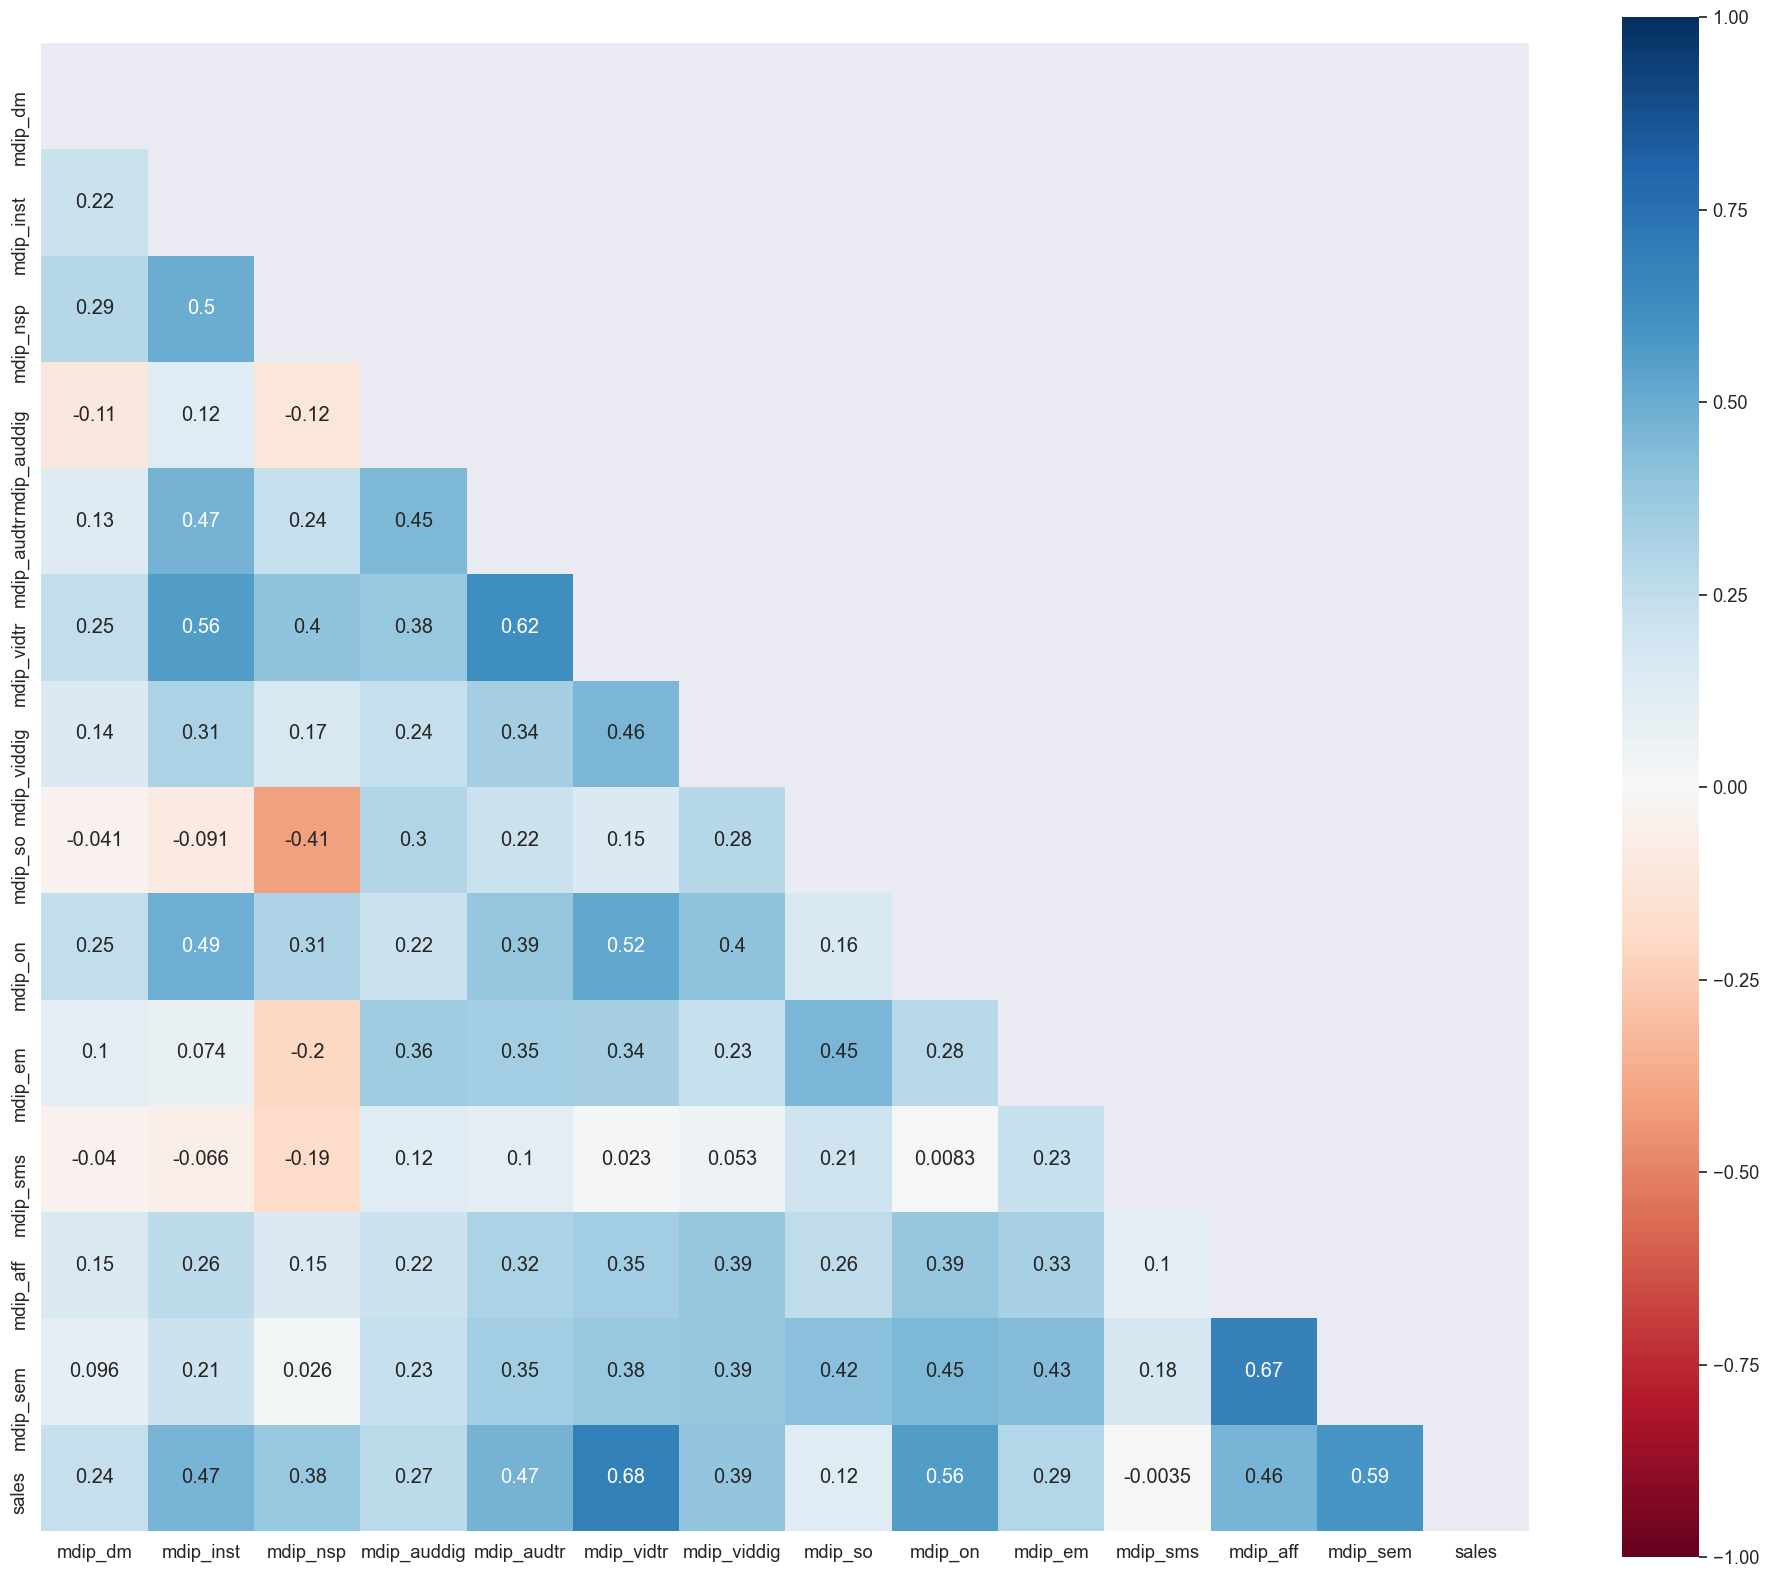

In [22]:
# Correlation plots
heatmap_df = df[mdip_cols+['sales']].copy()
corr_df = heatmap_df.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df)) 

plt.figure(figsize=(24,20))
sns.set_theme(font_scale=1.2)
sns.heatmap(corr_df, mask=mask, square=True,  annot=True, vmax=1, vmin=-1, cmap='RdBu')

In [23]:
corr_df

,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,mdip_sms,mdip_aff,mdip_sem,sales
mdip_dm,1.000000,0.223331,0.286132,-0.105631,0.128308,0.247709,0.140786,-0.041305,0.245293,0.102071,-0.040322,0.154615,0.095887,0.236064
mdip_inst,0.223331,1.000000,0.499008,0.118888,0.472533,0.555403,0.314052,-0.090806,0.487647,0.074305,-0.066214,0.261350,0.213595,0.466696
mdip_nsp,0.286132,0.499008,1.000000,-0.121775,0.239713,0.403139,0.171143,-0.412409,0.311374,-0.203453,-0.193084,0.150633,0.026412,0.375287
mdip_auddig,-0.105631,0.118888,-0.121775,1.000000,0.446020,0.378228,0.235080,0.301996,0.216696,0.358399,0.123434,0.215237,0.230229,0.266630
mdip_audtr,0.128308,0.472533,0.239713,0.446020,1.000000,0.619165,0.341369,0.219873,0.386453,0.349536,0.104463,0.319963,0.346581,0.471456
mdip_vidtr,0.247709,0.555403,0.403139,0.378228,0.619165,1.000000,0.455239,0.147786,0.519346,0.340018,0.023092,0.345883,0.376253,0.680728
mdip_viddig,0.140786,0.314052,0.171143,0.235080,0.341369,0.455239,1.000000,0.284460,0.403430,0.228650,0.053270,0.389112,0.385473,0.392341
mdip_so,-0.041305,-0.090806,-0.412409,0.301996,0.219873,0.147786,0.284460,1.000000,0.162958,0.454003,0.209515,0.256756,0.419650,0.117338
mdip_on,0.245293,0.487647,0.311374,0.216696,0.386453,0.519346,0.403430,0.162958,1.000000,0.278292,0.008327,0.388182,0.449283,0.557900
mdip_em,0.102071,0.074305,-0.203453,0.358399,0.349536,0.340018,0.228650,0.454003,0.278292,1.000000,0.228909,0.330988,0.430635,0.294009


In [24]:
corr_df['sales'].sort_values()

mdip_sms      -0.003498
mdip_so        0.117338
mdip_dm        0.236064
mdip_auddig    0.266630
mdip_em        0.294009
mdip_nsp       0.375287
mdip_viddig    0.392341
mdip_aff       0.461302
mdip_inst      0.466696
mdip_audtr     0.471456
mdip_on        0.557900
mdip_sem       0.590723
mdip_vidtr     0.680728
sales          1.000000
Name: sales, dtype: float64

Top three media variables...

__that are most positive correlated with Sales and should be considered to model:__

> mdip_vidtr (0.681)
    
> mdip_sem (0.591) 
    
> mdip_on (0.558)

__that are least correlated with Sales and might need to be engineered or excluded:__

> mdip_sms (-0.003)

> mdip_so (0.117)

> mdip_dm (0.236)
  
__that are highly correlated with other media variables and might need to be engineered if can't be added to the model:__

> mdip_audtr (with mdip_vidtr 0.619)

> mdip_viddig (with mdip_viddig  0.455)

> mdip_aff (with mdip_sem 0.674)

In [62]:
f"Since we have channels that do not have a cost column in the dataset for {mdip_only}, for the simplicity, I'm going to remove those channels."

"Since we have channels that do not have a cost column in the dataset for {'aff', 'sms', 'em'}, for the simplicity, I'm going to remove those channels."

In [ ]:

df.drop(columns=["mdip_" + i for i in mdip_only], inplace=True)
# Update media impression list
mdip_cols=[col for col in df.columns if 'mdip_' in col]
mdip_cols

['mdip_dm',
 'mdip_inst',
 'mdip_nsp',
 'mdip_auddig',
 'mdip_audtr',
 'mdip_vidtr',
 'mdip_viddig',
 'mdip_so',
 'mdip_on',
 'mdip_sem']

### Base Variable

<AxesSubplot: >

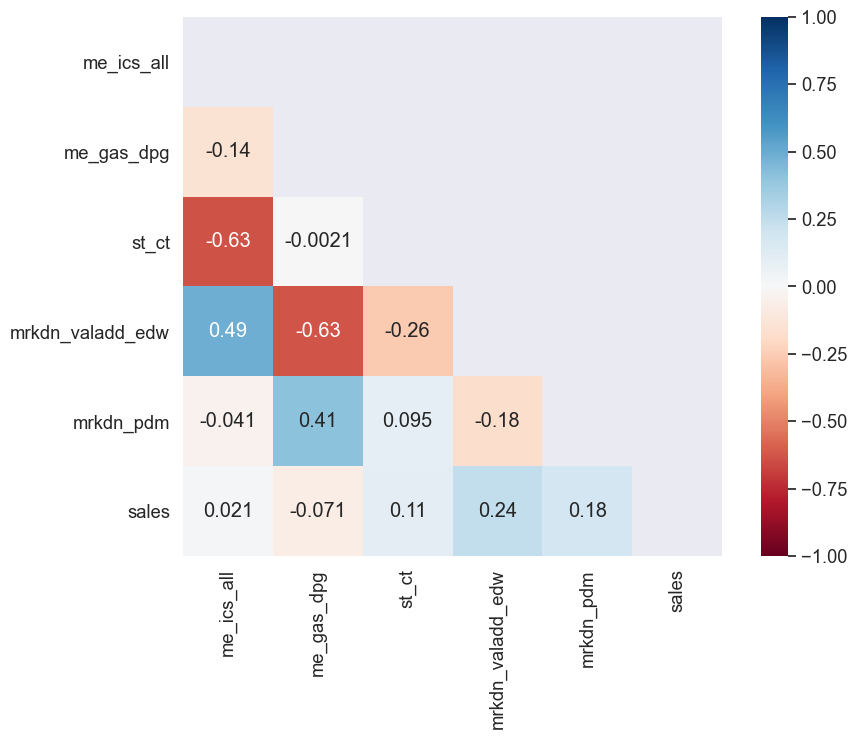

In [70]:
# EDA - correlation, distribution plots
heatmap_df = df[base_vars+['sales']].copy()
corr_df = heatmap_df.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df)) 

plt.figure(figsize=(10,7))
sns.set_theme(font_scale=1.2)
sns.heatmap(corr_df, mask=mask, square=True,  annot=True, vmax=1, vmin=-1, cmap='RdBu')

In [71]:
corr_df['sales'].sort_values()

me_gas_dpg         -0.071439
me_ics_all          0.020556
st_ct               0.105624
mrkdn_pdm           0.184419
mrkdn_valadd_edw    0.244617
sales               1.000000
Name: sales, dtype: float64

Top three base variables...

__that are most correlated with Sales and should be considered to model:__

> mrkdn_valadd_edw (0.244)
    
> mrkdn_pdm (0.184)
    
> st_ct (0.106)

# Modelling

Lightweight MMM uses a Bayesian modeling approach, which is based on probabilities and allows for greater flexibility in modeling complex relationships.

Besides we have spent and impressions for each channel, it's easy to use lightweightedMMM to run a simple MMM.

In [108]:
split_point = pd.Timestamp("2018-01-01") # 28 days to end of data
train_df = df[df['wk_strt_dt']<split_point].reset_index(drop=True)
test_df = df[df['wk_strt_dt']>=split_point].reset_index(drop=True)

media_data_train = train_df[mdip_cols]
media_data_test = test_df[mdip_cols]

base_data_train = train_df[base_vars]
base_data_test = test_df[base_vars]

target_train = train_df['sales']
target_test = test_df['sales']

costs_train = train_df[mdsp_cols].sum(axis=0)

In [127]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
base_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
base_data_train_scaled = base_scaler.fit_transform(base_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values)
target_test_scaled = target_scaler.fit_transform(target_test.values)

costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test.values)
base_data_test_scaled = base_scaler.transform(base_data_test.values)


Adstock: This method employs an infinite lag mechanism, progressively reducing the weight of a media channel’s impact as time advances.

Hill-Adstock: Here, a sigmoid-like function is applied to model diminishing returns in the output of the adstock function. This approach accommodates the nuanced effects of media influence.

Carryover: Operating with a causal convolution, this approach assigns greater weight to values closer in time and gradually decreases this weight for more distant values.

In [110]:
adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1]

for model_name in adstock_models:
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(media=media_data_train_scaled,
                media_prior=costs_scaled,
                target=target_train_scaled,
                extra_features=base_data_train,
                number_warmup=1000,
                number_samples=1000,
                number_chains=1,
                degrees_seasonality=degrees,
                weekday_seasonality=True,
                seasonality_frequency=365,
                seed=1)
        
        prediction = mmm.predict(
        media=media_data_test_scaled,
        extra_features=base_data_test_scaled,
        target_scaler=target_scaler)
        p = prediction.mean(axis=0)

        mape = mean_absolute_percentage_error(target_test.values, p)
        print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

sample: 100%|██████████| 2000/2000 [05:27<00:00,  6.11it/s, 511 steps of size 6.09e-03. acc. prob=0.94] 


model_name=adstock degrees=1 MAPE=2.8407720852950287 samples=[3.2275709e+08 2.9679194e+08 2.7815958e+08]


sample: 100%|██████████| 2000/2000 [05:04<00:00,  6.57it/s, 511 steps of size 6.22e-03. acc. prob=0.87] 


model_name=hill_adstock degrees=1 MAPE=3.0441540375969325 samples=[3.4771818e+08 3.3268739e+08 3.2023738e+08]


sample: 100%|██████████| 2000/2000 [4:42:26<00:00,  8.47s/it, 1023 steps of size 5.43e-03. acc. prob=0.94]     


model_name=carryover degrees=1 MAPE=2.1895815596400587 samples=[2.6572514e+08 2.3812546e+08 2.2000954e+08]


In [136]:
mmm.media_transforms

AttributeError: 'LightweightMMM' object has no attribute 'media_transforms'

In [ ]:
# rhat should be <1.1
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.56      0.28      0.58      0.15      1.00    703.09      1.00
ad_effect_retention_rate[1]      0.45      0.29      0.42      0.01      0.89    880.58      1.00
ad_effect_retention_rate[2]      0.41      0.28      0.36      0.00      0.85    542.17      1.00
ad_effect_retention_rate[3]      0.50      0.29      0.50      0.00      0.89   1036.98      1.00
ad_effect_retention_rate[4]      0.55      0.31      0.57      0.11      1.00   1140.56      1.00
ad_effect_retention_rate[5]      0.14      0.13      0.10      0.00      0.32    893.70      1.00
ad_effect_retention_rate[6]      0.51      0.28      0.51      0.11      0.97   1098.12      1.00
ad_effect_retention_rate[7]      0.50      0.29      0.51      0.03      0.93    970.46      1.00
ad_effect_retention_rate[8]      0.53      0.29      0.55      0.11      1.00    969.83      1.00
ad_effect_retention

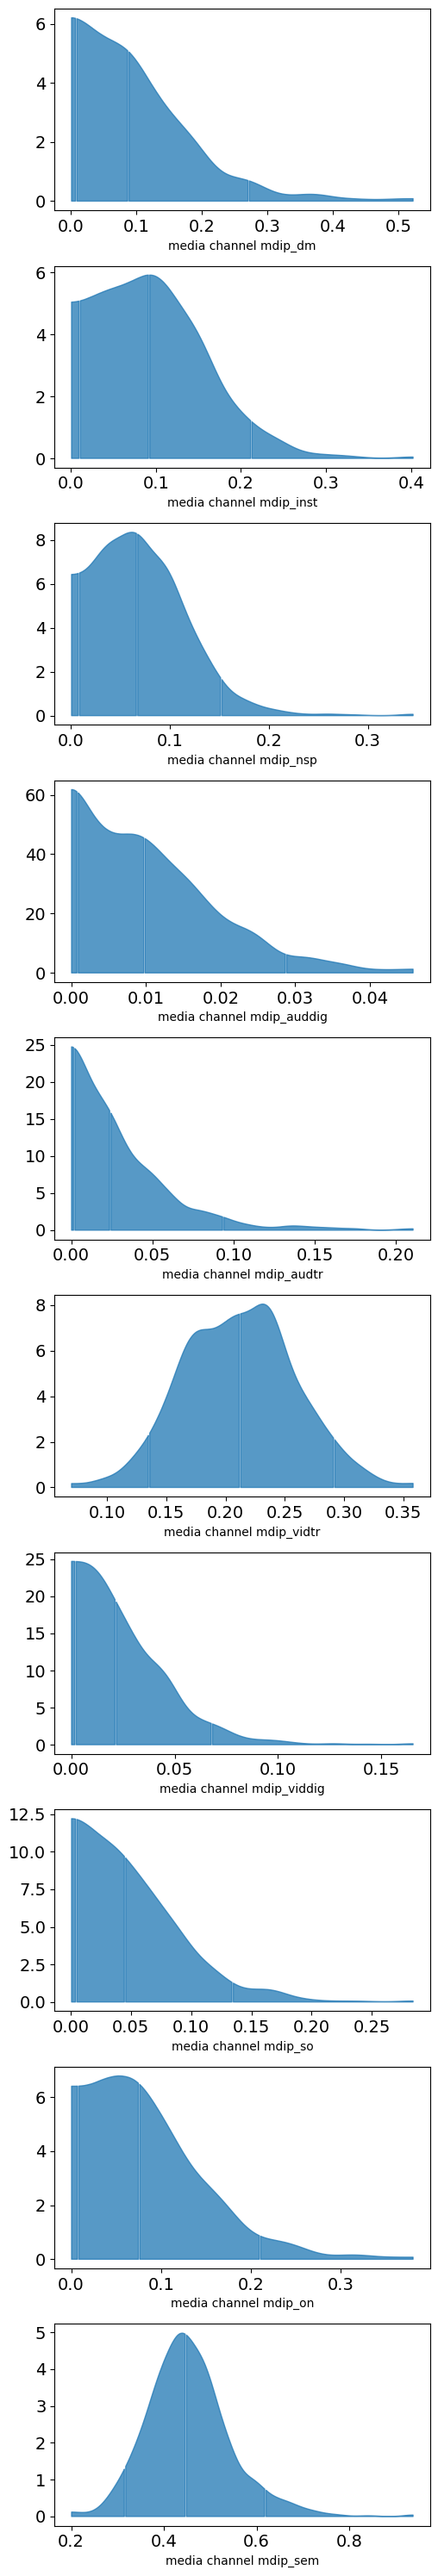

In [114]:
plot.plot_media_channel_posteriors(media_mix_model=mmm,
                                   channel_names=mdip_cols)

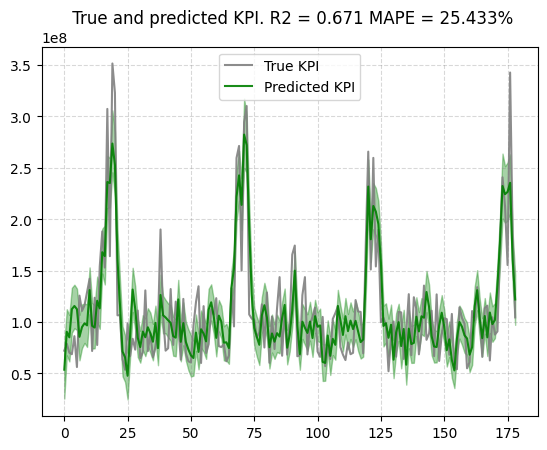

In [118]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [129]:
prediction=mmm.predict(extra_features=base_data_test_scaled, media=media_data_test_scaled)
prediction.shape

(1000, 30)

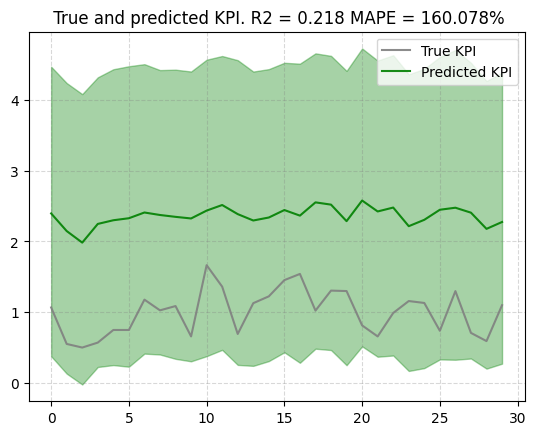

In [131]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=prediction, out_of_sample_target=target_test_scaled)